#Alunos
Lucas de Almeida Carvalho.

Marcelo Silva.

Emiliano Maresca.

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import metrics, preprocessing
import seaborn as sns
import pandas as pd
import math
import skimage.feature as feature
import zipfile
import glob
import matplotlib.style as sty
import itertools
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras import regularizers
from keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

In [ ]:
!mkdir treino

In [ ]:
!mkdir teste

In [ ]:
!wget https://github.com/andrehochuli/teaching/blob/main/ComputerVision/Lecture%2008%20-%20Classification/basesimpsons.zip?raw=true -O basesimpsons.zip
!unzip basesimpsons.zip

--2022-11-18 20:59:04--  https://github.com/andrehochuli/teaching/blob/main/ComputerVision/Lecture%2008%20-%20Classification/basesimpsons.zip?raw=true
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/andrehochuli/teaching/raw/main/ComputerVision/Lecture%2008%20-%20Classification/basesimpsons.zip [following]
--2022-11-18 20:59:04--  https://github.com/andrehochuli/teaching/raw/main/ComputerVision/Lecture%2008%20-%20Classification/basesimpsons.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/andrehochuli/teaching/main/ComputerVision/Lecture%2008%20-%20Classification/basesimpsons.zip [following]
--2022-11-18 20:59:04--  https://raw.githubusercontent.com/andrehochuli/teaching/main/ComputerVision/Lecture%2008%20-%20Classification/basesimpsons.zi

In [ ]:
#Extração da base de treino para a pasta Treino
with zipfile.ZipFile('Treino.zip','r') as zip_ref:
  zip_ref.extractall('treino')

In [ ]:
#Extração da base de treino para a pasta Teste
with zipfile.ZipFile('Teste.zip','r') as zip_ref:
  zip_ref.extractall('teste')

#Funções e carregamento de base


In [ ]:
def plot_confusion_matrix(cm, classes,normalize=False,title=None,cmap=plt.cm.Greens):
  plt.imshow(cm, interpolation = 'nearest',cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation = 45)
  plt.yticks(tick_marks, classes)
  
  if normalize:
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    print("Normalized confusion matrix")
  else:
    print("Confusion matrix, without normalization")
  
  print(cm)
  
  thresh = cm.max()/2
  for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
    plt.text(j, i, cm[i,j], horizontalalignment="center", color="white" if cm[i,j]>thresh else "black")
   
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

In [ ]:
#Auxiliary Function to plot side by side
def plot_sidebyside(img_list,titles,colormap=None,figsize=(12,6)):
  n = len(img_list)
  figure, axis = plt.subplots(1, n, figsize=figsize)

  for i in range(n):
    axis[i].imshow(img_list[i], cmap=colormap)
    axis[i].set_title(titles[i])
    axis[i].axis('off')
  # Combine all the operations and display
  plt.show()

In [ ]:
def categorical_label(name):
  if name == 'homer':
    id = 0
  elif name == 'marge':
    id = 1
  elif name == 'bart':
    id = 2
  elif name == 'lisa':
    id = 3
  elif name == 'maggie':
    id = 4
  else:
    id = 5
  return id

lbls_name = ['HOMER','MARGE','BART','LISA','MAGGIE','FAMILY']
lbls_nro = [0,1,2,3,4,5]
path_treino = '/content/treino/'
path_teste = '/content/teste/'  

In [ ]:
def plot_history(history):
  print(history.history.keys())
  # summarize history for accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

In [ ]:
#Carregamento de base treino
import os
file_list=[]
file_list.append(os.listdir(r"/content/treino"))

In [ ]:
#Carregamento de base teste
import os
file_list_teste=[]
file_list_teste.append(os.listdir(r"/content/teste"))

In [ ]:
X_train = []
y_train = []
for classes_files, classe in zip (file_list, range(5)):
  for i in range(len(classes_files)):
        original = cv2.imread(path_treino+classes_files[i])
        name= str(classes_files[i])
        name = name[0:(len(name)-7)]
        original = cv2.cvtColor(original,cv2.COLOR_BGR2RGB)
        original = cv2.resize(original,(200,200), interpolation=cv2.INTER_AREA)
        X_train.append(original)
        id = categorical_label(name)
        y_train.append(id)

X_train = np.array(X_train)
y_train = np.array(y_train)

In [ ]:
X_test = []
y_test = []

for classes_files, classe in zip (file_list_teste, range(5)):
  for i in range(len(classes_files)):
        original = cv2.imread(path_teste+classes_files[i])
        name= str(classes_files[i])
        name = name[0:(len(name)-7)]
        original = cv2.cvtColor(original,cv2.COLOR_BGR2RGB)
        original = cv2.resize(original,(200,200), interpolation=cv2.INTER_AREA)
        X_test.append(original)
        id = categorical_label(name)
        y_test.append(id)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Plot Samples

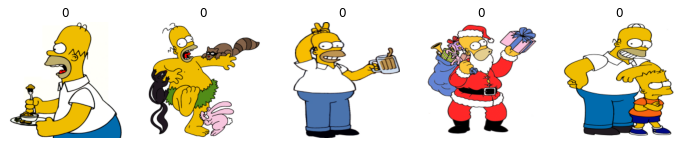

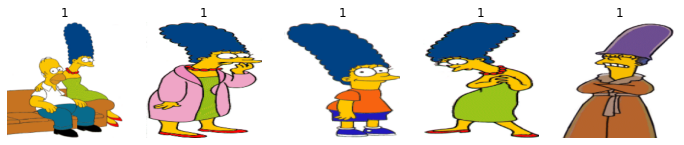

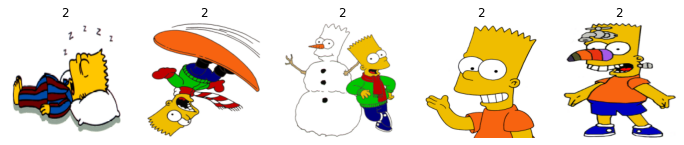

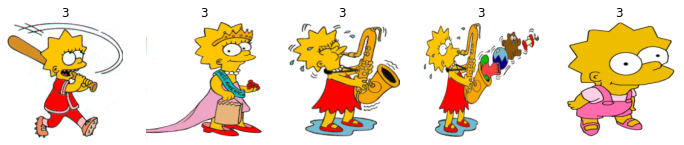

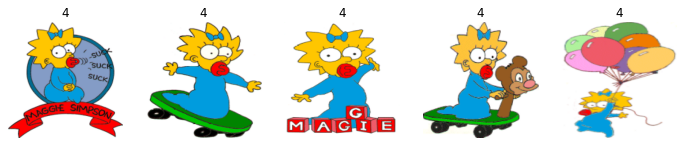

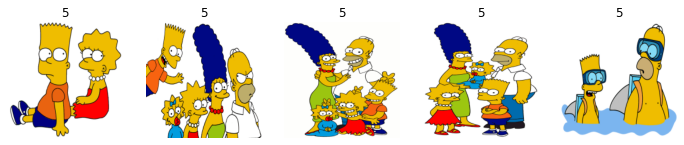

In [ ]:
N_CLASSES = 6
N_SAMPLES = 5
for i in range(N_CLASSES):
  idxs = np.where(y_train == i)[0]
  idxs = idxs[:N_SAMPLES]
  plot_sidebyside(X_train[idxs],y_train[idxs],'gray')

#Parâmetros Globais
Definição de número de classes do problema, o tamanho do batch de imagens que correrá o modelo a cada iteração e o número de épocas.

In [ ]:
batch_size = 64
num_classes = 6
epochs = 20

#1° Modelo - 5 Layers
Para este modelo, foram utilizadas 5 layers de 32, 64, 64, 128 e 64 filtros, respectivamente e tamanho 3x3. Após cada filtro, foi inserido uma camada de Max Pooling de matrix 2x2.

In [ ]:
from numpy.random.mtrand import seed
model = Sequential()

#32 layers of size 3x3 and Relu Activation
model.add(layers.Rescaling(1./255,input_shape=X_train.shape[1:]))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes,activation='softmax'))

model.summary()

model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

results_default = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.3)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 99, 99, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 48, 48, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 46, 46, 64)       

##Avaliação de métricas e resultados na base de teste
Abaixo encontramos o resultado da acurácia e do loss quando avaliados na base de teste e logo em seguida podemos acompanhar a evolução destas mesmas métricas entre as bases de treino e de validação.

Test loss:  1.8036432266235352
Test accuracy:  0.43396225571632385
------------------------
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


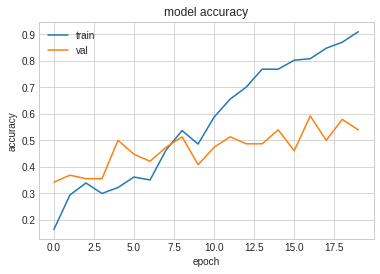

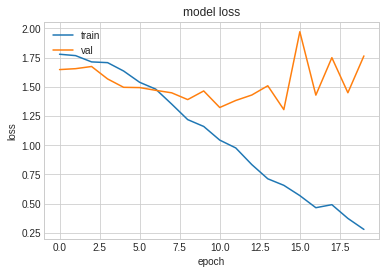

In [ ]:
# Executar a avaliação (teste)
score=model.evaluate(X_test, y_test, verbose=0)
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])
print('------------------------')

plot_history(results_default)

4/4 [==============================] - 0s 16ms/step
Confusion matrix, without normalization
[[ 8  0  8  6  2  1]
 [ 0  5  3  0  0  2]
 [ 3  0 20 10  2  0]
 [ 2  0  5  5  0  1]
 [ 0  0  6  0  6  0]
 [ 2  1  5  1  0  2]]


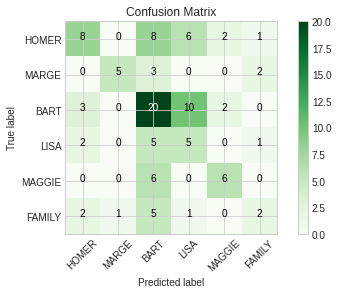

In [ ]:
# Predição da CNN
y_predict=np.argmax(model.predict(X_test), axis=1)

# Preparar Matriz de Confusão
cm=confusion_matrix(y_test, y_predict)
plot_confusion_matrix(cm, lbls_name, title= 'Confusion Matrix')

##Comentário sobre resultados
Podemos perceber que após a época 12, aproximadamente, temos uma oscilação da acurácia e do loss, sem ganhos/perdas muito significativas. Com a tentativa de treino por mais épocas, constatamos que não há evolução do aprendizado, por este motivo utilizamos apenas 20 épocas por default.
Avaliando a matriz de confusão, observamos que o modelo teve uma distribuição boa de acertos, com uma incidência maior que erros para a classe BART e HOMMER

**Acurácia na base de teste: 43%**

#1° Modelo V.2 - 5 Layers e Data Generator
Para este modelo também utilizamos 5 layers de 32, 64, 64, 128 e 64 filtros, respectivamente e tamanho 3x3. Após cada filtro, mantemos a camada de  Max Pooling de matriz 2x2, porém antes do treinamento, aplicamos algumas técnicas de data augmentation para popular nosso dataset de treino e validação e ter mais exemplos disponíveis para treino.

In [ ]:
#Parametrização do gerador de imagens
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
)

#Separação do dataset entre treino e validação
trainX, valX, trainY, valY = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
#Geração de novo dataset de treino e validação aplicando as técnicas de image augmentation
train_generator = datagen.flow(trainX, trainY, batch_size=batch_size)
val_generator = datagen.flow(valX, valY, batch_size=batch_size)

#Treinamento do modelo utilizando os novos datasets gerados
results_default_imd = model.fit(train_generator, batch_size=batch_size, epochs=25, validation_data=val_generator)

Epoch 1/25
4/4 [==============================] - 4s 1s/step - loss: 0.4084 - accuracy: 0.8564 - val_loss: 1.5306 - val_accuracy: 0.7059
Epoch 2/25
4/4 [==============================] - 2s 492ms/step - loss: 0.2953 - accuracy: 0.9257 - val_loss: 1.8223 - val_accuracy: 0.7255
Epoch 3/25
4/4 [==============================] - 2s 508ms/step - loss: 0.2037 - accuracy: 0.9109 - val_loss: 1.7484 - val_accuracy: 0.7059
Epoch 4/25
4/4 [==============================] - 2s 659ms/step - loss: 0.2550 - accuracy: 0.9109 - val_loss: 2.0977 - val_accuracy: 0.6078
Epoch 5/25
4/4 [==============================] - 2s 503ms/step - loss: 0.2520 - accuracy: 0.9059 - val_loss: 1.5995 - val_accuracy: 0.6863
Epoch 6/25
4/4 [==============================] - 2s 492ms/step - loss: 0.2827 - accuracy: 0.8812 - val_loss: 1.6192 - val_accuracy: 0.7255
Epoch 7/25
4/4 [==============================] - 2s 496ms/step - loss: 0.2168 - accuracy: 0.9208 - val_loss: 1.6609 - val_accuracy: 0.6275
Epoch 8/25
4/4 [=======

##Avaliação de métricas e resultados na base de teste
Abaixo encontramos o resultado da acurácia e do loss quando avaliados na base de teste e logo em seguida podemos acompanhar a evolução destas mesmas métricas entre as bases de treino e de validação.

Test loss:  1.6925129890441895
Test accuracy:  0.650943398475647
-------------------------
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


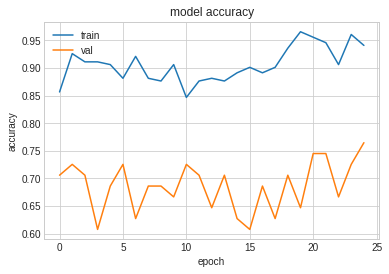

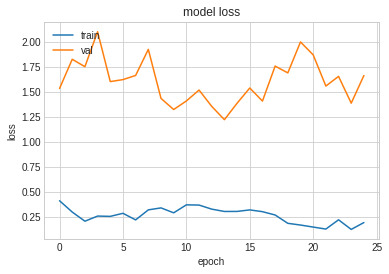

In [ ]:
# Executar a avaliação (teste)
score_dataAUG=model.evaluate(X_test, y_test, verbose=0)
print('Test loss: ', score_dataAUG[0])
print('Test accuracy: ', score_dataAUG[1])

print('-------------------------')
plot_history(results_default_imd)

4/4 [==============================] - 0s 16ms/step
Confusion matrix, without normalization
[[14  0  4  3  1  3]
 [ 0  7  0  0  0  3]
 [ 5  0 27  2  1  0]
 [ 3  0  5  5  0  0]
 [ 0  0  1  0 11  0]
 [ 2  2  2  0  0  5]]


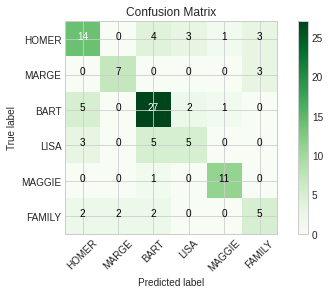

In [ ]:
# Predição da CNN
y_predict=np.argmax(model.predict(X_test), axis=1)

# Preparar Matriz de Confusão
cm=confusion_matrix(y_test, y_predict)
plot_confusion_matrix(cm, lbls_name, title= 'Confusion Matrix')

##Comentário sobre resultados
Para este modelo, percebemos uma possibilidade de melhora de resultados na validação, desta forma decidimos adicionar mais 5 épocas ao treinamento default, porém percebemos que após a 20° época o modelo não aumenta a acurácia significantemente. 

Avaliando a matriz de confusão, percebemos uma melhora significante se comparado ao modelo treinado sem Data Augmentation, os erros ainda se concentram nas classes HOMER e BART, pois são as que mais possuem exemplos no teste, porém agora tendo muito mais casos de acertos. 

**Acurácia no teste de 65%.**

#_______________________________________________

#2° Modelo - 5 Layers + Dropout
Para este segundo modelo, instanciamos algumas camadas de dropout aleatóriamente após a 2° e 4° camada. Utilizaremos 30% e 20%, respectivamente, em cada camada de Dropout. Como primeira avaliação, utilizaremos a base original sem aplicação de data augmentation.

In [ ]:
model_dropout = Sequential()

#32 layers of size 3x3 and Relu Activation
model_dropout.add(layers.Rescaling(1./255,input_shape=X_train.shape[1:]))

model_dropout.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_dropout.add(layers.MaxPooling2D((2, 2)))

model_dropout.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_dropout.add(layers.MaxPooling2D((2, 2)))
model_dropout.add(Dropout(0.3))

model_dropout.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_dropout.add(layers.MaxPooling2D((2, 2)))

model_dropout.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_dropout.add(layers.MaxPooling2D((2, 2)))
model_dropout.add(Dropout(0.2))

model_dropout.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_dropout.add(layers.MaxPooling2D((2, 2)))


model_dropout.add(layers.Flatten())
model_dropout.add(layers.Dense(128, activation='relu'))
model_dropout.add(layers.Dense(num_classes,activation='softmax'))

model_dropout.summary()

model_dropout.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

results_default_dropout = model_dropout.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.3)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d_25 (Conv2D)          (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 99, 99, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 48, 48, 64)       0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 48, 48, 64)       

##Avaliação de métricas e resultados na base de teste
Abaixo encontramos o resultado da acurácia e do loss quando avaliados na base de teste e logo em seguida podemos acompanhar a evolução destas mesmas métricas entre as bases de treino e de validação.

Test loss:  1.4680757522583008
Test accuracy:  0.5377358198165894
---------------------
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


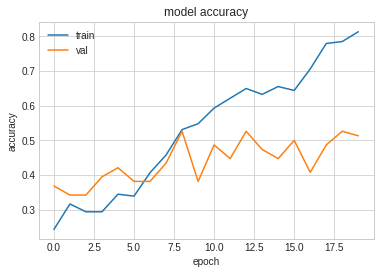

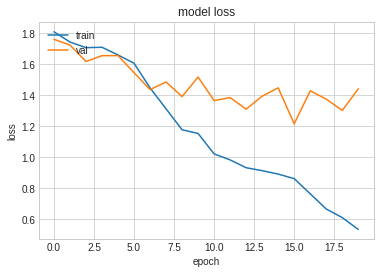

In [ ]:
# Executar a avaliação (teste)
score_dropout=model_dropout.evaluate(X_test, y_test, verbose=0)
print('Test loss: ', score_dropout[0])
print('Test accuracy: ', score_dropout[1])
print('---------------------')
plot_history(results_default_dropout)

4/4 [==============================] - 0s 16ms/step
Confusion matrix, without normalization
[[ 8  0 12  3  2  0]
 [ 0  6  3  1  0  0]
 [ 3  0 21  9  2  0]
 [ 1  0  2 10  0  0]
 [ 1  0  3  0  8  0]
 [ 0  1  4  2  0  4]]


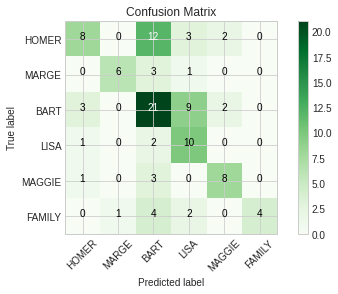

In [ ]:
# Predição da CNN
y_predict=np.argmax(model_dropout.predict(X_test), axis=1)

# Preparar Matriz de Confusão
cm=confusion_matrix(y_test, y_predict)
plot_confusion_matrix(cm, lbls_name, title= 'Confusion Matrix')

##Comentário sobre resultados
Perceptível que após a época 12, temos uma variação muito baixa da métrica de acurácia, o que tende a se repetir caso treinado por mais épocas. Podemos notar também que a métrica de loss cresce exponencialmente na base de validação, por este motivo determinamos como o default de 20 épocas.

Na matriz de confusão, observamos que as classes HOMER e FAMILY tiveram um grande número de erros.

**Acurácia no treinamento: 53%**

#2° Modelo V2 - 5 Layers, Dropout e Data Generator
Neste novo experimento, o treinamento do modelo será realizado com a técnica de image augmentation na base de treino e validação, retornando assim, mais exemplos para o treinamento.

In [ ]:
#Parametrização do gerador de imagens
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
)

#Separação do dataset entre treino e validação
trainX, valX, trainY, valY = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
#Geração de novo dataset de treino e validação aplicando as técnicas de image augmentation
train_generator = datagen.flow(trainX, trainY, batch_size=batch_size)
val_generator = datagen.flow(valX, valY, batch_size=batch_size)

#Treinamento do modelo utilizando os novos datasets gerados
results_dropout_imd = model_dropout.fit(train_generator, batch_size=batch_size, epochs=epochs, validation_data=val_generator)

Epoch 1/20
4/4 [==============================] - 3s 800ms/step - loss: 0.5247 - accuracy: 0.7921 - val_loss: 1.3219 - val_accuracy: 0.5294
Epoch 2/20
4/4 [==============================] - 2s 489ms/step - loss: 0.5616 - accuracy: 0.7772 - val_loss: 1.1749 - val_accuracy: 0.6667
Epoch 3/20
4/4 [==============================] - 2s 484ms/step - loss: 0.4661 - accuracy: 0.8317 - val_loss: 1.2820 - val_accuracy: 0.5882
Epoch 4/20
4/4 [==============================] - 2s 495ms/step - loss: 0.4716 - accuracy: 0.8218 - val_loss: 1.1776 - val_accuracy: 0.6667
Epoch 5/20
4/4 [==============================] - 2s 497ms/step - loss: 0.4510 - accuracy: 0.8267 - val_loss: 1.1375 - val_accuracy: 0.6275
Epoch 6/20
4/4 [==============================] - 2s 647ms/step - loss: 0.3969 - accuracy: 0.8317 - val_loss: 1.2392 - val_accuracy: 0.6471
Epoch 7/20
4/4 [==============================] - 2s 576ms/step - loss: 0.4539 - accuracy: 0.8168 - val_loss: 1.5886 - val_accuracy: 0.5294
Epoch 8/20
4/4 [====

##Avaliação de métricas e resultados na base de teste
Abaixo encontramos o resultado da acurácia e do loss quando avaliados na base de teste e logo em seguida podemos acompanhar a evolução destas mesmas métricas entre as bases de treino e de validação.

Test loss:  1.163791298866272
Test accuracy:  0.6698113083839417
-------------------
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


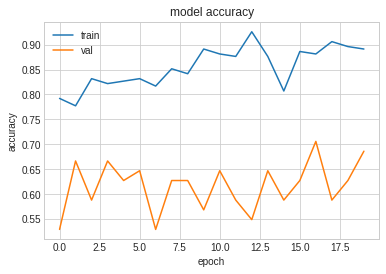

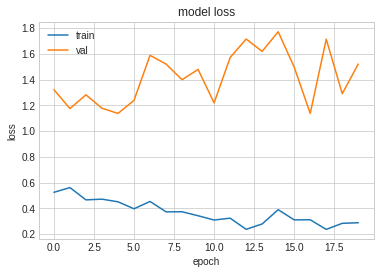

In [ ]:
# Executar a avaliação (teste)
score_dropoutdataAUG=model_dropout.evaluate(X_test, y_test, verbose=0)
print('Test loss: ', score_dropoutdataAUG[0])
print('Test accuracy: ', score_dropoutdataAUG[1])
print('-------------------')
plot_history(results_dropout_imd)

4/4 [==============================] - 0s 16ms/step
Confusion matrix, without normalization
[[16  0  2  4  1  2]
 [ 0  9  0  0  0  1]
 [ 6  0 24  2  1  2]
 [ 2  0  1  9  1  0]
 [ 1  0  2  0  9  0]
 [ 3  1  2  1  0  4]]


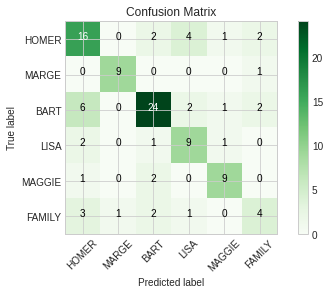

In [ ]:
# Predição da CNN
y_predict=np.argmax(model_dropout.predict(X_test), axis=1)

# Preparar Matriz de Confusão
cm=confusion_matrix(y_test, y_predict)
plot_confusion_matrix(cm, lbls_name, title= 'Confusion Matrix')

##Comentário sobre resultados
Perceptível que com apenas 20 épocas, temos um resultado interessante de acurácia, desta forma, não é interessante demandar o treinamento por mais épocas. Além de que não há sinais que de a métrica será incrementada em novas épocas.
Na matriz de confusão, encontramos um número menor de confusão entre a classe HOMER, porém para exemplos da classe FAMILY ainda temos bastante confusão entre HOMER, MARGE e BART.

**Acurácia na base de treino: 66%**


#__________

#Transfer Learning
Nesta etapa do notebook, optamos por adicionar técnicas de transfer learning, treinando modelos com um misto de base original, dropout e Data Augmentation. 

#Resnet 50 V.1 - Base Original
Utilização da rede ResNet50 com pesos da Imagenet, aplicado apenas o Rescaling para manter os valores entre 0 e 1, uma camada Flatter e uma camada Densa de 128. 

 

In [ ]:
conv_layers =  tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top=False,input_tensor=tf.keras.layers.Input(X_train.shape[1:]),classes=num_classes)
conv_layers.trainable = False

model_resnet_org = tf.keras.Sequential([
    conv_layers,
    layers.Rescaling(1./255),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model_resnet_org.summary()

model_resnet_org.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

result_resnet_org = model_resnet_org.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.3)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 rescaling_7 (Rescaling)     (None, 7, 7, 2048)        0         
                                                                 
 flatten_7 (Flatten)         (None, 100352)            0         
                                                                 
 dense_14 (Dense)            (None, 128)               12845184  
                                                                 
 dense_15 (Dense)            (None, 6)                 774       
                                                                 
Total params: 36,433,670
Trainable params: 12,845,958
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/20
3/3 [=================

##Avaliação de resultados na base de teste.
Abaixo encontramos o resultado da acurácia e do loss quando avaliados na base de teste e logo em seguida podemos acompanhar a evolução destas mesmas métricas entre as bases de treino e de validação.

Test loss:  0.8297985792160034
Test accuracy:  0.6698113083839417
-----------------
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


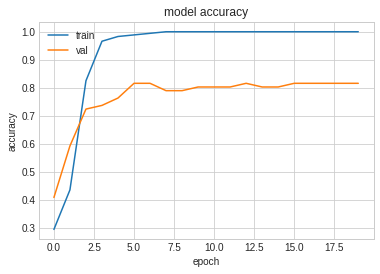

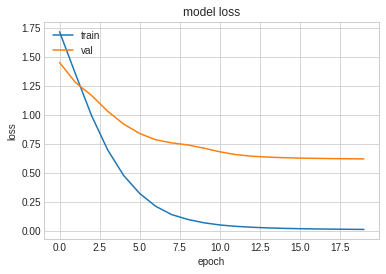

In [ ]:
# Executar a avaliação (teste)
score_resnet_org=model_resnet_org.evaluate(X_test, y_test, verbose=0)
print('Test loss: ', score_resnet_org[0])
print('Test accuracy: ', score_resnet_org[1])
print('-----------------')
plot_history(result_resnet_org)

4/4 [==============================] - 1s 104ms/step
Confusion matrix, without normalization
[[15  0  7  0  1  2]
 [ 1  5  3  0  0  1]
 [ 2  0 33  0  0  0]
 [ 1  0  4  6  1  1]
 [ 2  0  4  1  5  0]
 [ 1  0  3  0  0  7]]


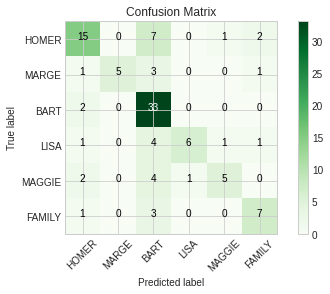

In [ ]:
# Predição da CNN
y_predict=np.argmax(model_resnet_org.predict(X_test), axis=1)

# Preparar Matriz de Confusão
cm=confusion_matrix(y_test, y_predict)
plot_confusion_matrix(cm, lbls_name, title= 'Confusion Matrix')

##Comentário sobre resultados
É possível notar que já na época 5, aproximadamente, o modelo atinge 100% de acurária na base de treino e a base de validação atinge seu pico de acurácia, após este ponto, não há variações significativas de aprendizado, desta forma mantemos as 20 épocas como default. 

Analisando a matriz de confusão, percebemos que o modelo teve uma performance boa, errando apenas alguns exemplos das classes HOMER, MARGE, LISA e MAGGIE.

**Acurácia na base de teste: 66%**

#Resnet 50 V.2 - Base Original + Dropout
Utilização da rede ResNet50 com pesos da Imagenet, aplicando o Rescaling para manter os valores entre 0 e 1, uma camada de dropout de 30%, uma camada Flatter e uma camada Densa de 128. 

 

In [ ]:
conv_layers =  tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top=False,input_tensor=tf.keras.layers.Input(X_train.shape[1:]),classes=num_classes)
conv_layers.trainable = False

model_resnet_drp = tf.keras.Sequential([
    conv_layers,
    layers.Rescaling(1./255),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model_resnet_drp.summary()

epochs_ = 20
model_resnet_drp.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

result_resnet = model_resnet_drp.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.3)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 rescaling_10 (Rescaling)    (None, 7, 7, 2048)        0         
                                                                 
 dropout_6 (Dropout)         (None, 7, 7, 2048)        0         
                                                                 
 flatten_10 (Flatten)        (None, 100352)            0         
                                                                 
 dense_20 (Dense)            (None, 128)               12845184  
                                                                 
 dense_21 (Dense)            (None, 6)                 774       
                                                                 
Total params: 36,433,670
Trainable params: 12,845,958

##Avaliação de resultados na base de teste.
Abaixo encontramos o resultado da acurácia e do loss quando avaliados na base de teste e logo em seguida podemos acompanhar a evolução destas mesmas métricas entre as bases de treino e de validação.

Test loss:  0.8475887179374695
Test accuracy:  0.6603773832321167
--------------
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


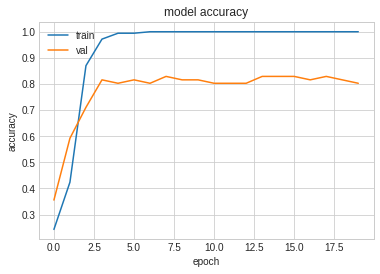

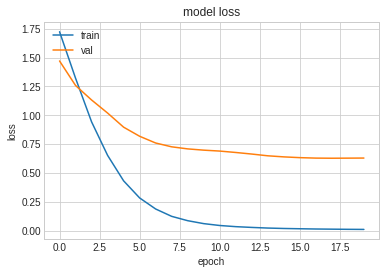

In [ ]:
# Executar a avaliação (teste)
score_resnet=model_resnet_drp.evaluate(X_test, y_test, verbose=0)
print('Test loss: ', score_resnet[0])
print('Test accuracy: ', score_resnet[1])
print('--------------')
plot_history(result_resnet)


4/4 [==============================] - 1s 95ms/step
Confusion matrix, without normalization
[[14  0  9  0  1  1]
 [ 1  5  4  0  0  0]
 [ 2  0 33  0  0  0]
 [ 1  0  5  5  1  1]
 [ 1  0  4  1  6  0]
 [ 1  0  3  0  0  7]]


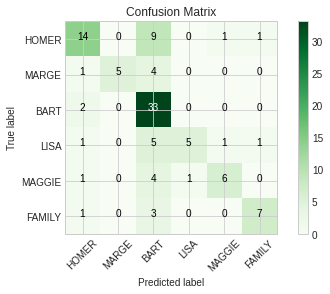

In [ ]:
# Predição da CNN
y_predict=np.argmax(model_resnet_drp.predict(X_test), axis=1)

# Preparar Matriz de Confusão
cm=confusion_matrix(y_test, y_predict)
plot_confusion_matrix(cm, lbls_name, title= 'Confusion Matrix')

##Comentário sobre resultados
Perceptível que, como no modelo anterior sem dropout, o modelo atinge 100% de acurácia na base de treino já nas primeiras 5 épocas, o que não acarreta em uma melhora significante da acurácia na base de validação nas demais épocas que vem a seguir. 
Analisando a matriz de confusão, podemos constatar que a maior incidência de erros permanecem nas classes LISA, MAGGIE e FAMILY.

**Acurácia na base de teste: 66%**

#Resnet 50 V.3 - Dropout + Data Augmentation
Utilização da rede ResNet50 com pesos da Imagenet, aplicando o Rescaling para manter os valores entre 0 e 1, uma camada de dropout de 30%, uma camada Flatter e uma camada Densa de 128. Para este exemplo, antes do treinamento do modelo, aplicamos uma técnica de Data Augmentation, direcionando certos efeitos na imagem (Zoom, rotação e etc) para aumentar os exemplos disponíveis.  

In [ ]:
conv_layers =  tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top=False,input_tensor=tf.keras.layers.Input(X_train.shape[1:]),classes=num_classes)
conv_layers.trainable = False

model_resnetDAU = tf.keras.Sequential([
    conv_layers,
    layers.Rescaling(1./255),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model_resnetDAU.summary()

epochs_ = 20
model_resnetDAU.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

datagenRes = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    )

trainX, valX, trainY, valY = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
train_generator = datagenRes.flow(trainX, trainY, batch_size=batch_size)
val_generator = datagenRes.flow(valX, valY, batch_size=batch_size)

result_resnet_DAU = model_resnetDAU.fit(train_generator, batch_size=batch_size, epochs=40, validation_data=val_generator)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 rescaling_14 (Rescaling)    (None, 7, 7, 2048)        0         
                                                                 
 flatten_14 (Flatten)        (None, 100352)            0         
                                                                 
 dense_28 (Dense)            (None, 128)               12845184  
                                                                 
 dense_29 (Dense)            (None, 6)                 774       
                                                                 
Total params: 36,433,670
Trainable params: 12,845,958
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/40
4/4 [================

##Avaliação de resultados na base de teste.
Abaixo encontramos o resultado da acurácia e do loss quando avaliados na base de teste e logo em seguida podemos acompanhar a evolução destas mesmas métricas entre as bases de treino e de validação.

Test loss:  1.020617961883545
Test accuracy:  0.6886792182922363
--------------
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


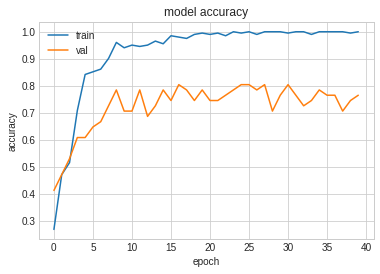

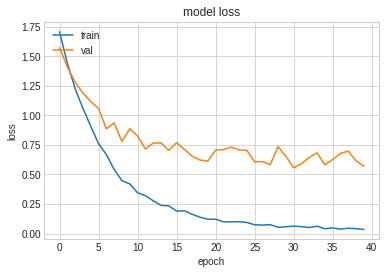

In [ ]:
# Executar a avaliação (teste)
score_resnet_DAU=model_resnetDAU.evaluate(X_test, y_test, verbose=0)
print('Test loss: ', score_resnet_DAU[0])
print('Test accuracy: ', score_resnet_DAU[1])
print('--------------')
plot_history(result_resnet_DAU)


4/4 [==============================] - 2s 94ms/step
Confusion matrix, without normalization
[[22  1  2  0  0  0]
 [ 1  7  2  0  0  0]
 [ 4  0 31  0  0  0]
 [ 2  0  7  3  0  1]
 [ 2  0  5  0  5  0]
 [ 5  0  1  0  0  5]]


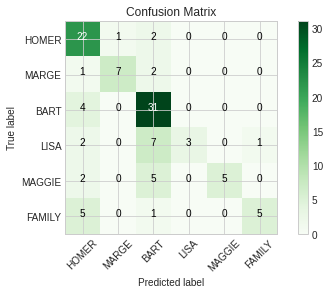

In [ ]:
# Predição da CNN
y_predict=np.argmax(model_resnetDAU.predict(X_test), axis=1)

# Preparar Matriz de Confusão
cm=confusion_matrix(y_test, y_predict)
plot_confusion_matrix(cm, lbls_name, title= 'Confusion Matrix')

##Comentário sobre resultados
Perceptível que existe um range entre a acurácia de treino e de validação em torno de 20%, porém não há indicios de melhora desta curva, desta forma não há necessidade de adicionar mais épocas pois o resultado não terá grandes incrementos 
Analisando a matriz de confusão, podemos constatar que a maior incidência de erros ocorreu de atribuição da classe HOMER quando na verdade seria uma das demais 5 classes, ou seja, embora a acurácia tenha batido um resultado mais alto na base de teste, este modelo é suscetível a apresentar mais erros. 

**Acurácia na base de teste: 68%**